In [ ]:
#using smote
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
import pandas as pd
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

# Load the dataset from a CSV file
data = pd.read_csv('/content/Dataset of Heart failure Prediction.csv')
X = data.iloc[:, :-1].values  # input features
y = data.iloc[:, -1].values  # output labels

# Encode categorical columns
label_encoders = {}
categorical_columns = [1, 2, 6, 8, 10]  # Column indices of categorical features
for col_idx in categorical_columns:
    label_encoders[col_idx] = LabelEncoder()
    X[:, col_idx] = label_encoders[col_idx].fit_transform(X[:, col_idx])

# Convert data to the appropriate data type (float)
X = X.astype(float)
y = y.astype(float)

# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the data into three client datasets
client1_X, client1_y = X_smote[:300, :], y_smote[:300]
client2_X, client2_y = X_smote[300:600, :], y_smote[300:600]
client3_X, client3_y = X_smote[600:, :], y_smote[600:]

# Define hyperparameter grids for models
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the models with GridSearchCV for hyperparameter tuning
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=5, n_jobs=-1)
et_model = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the models on the client data
rf_model.fit(client1_X, client1_y)
et_model.fit(client2_X, client2_y)

# Get the best-tuned models
best_rf_model = rf_model.best_estimator_
best_et_model = et_model.best_estimator_

# Create an ensemble of the best models
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('et', best_et_model),
], voting='hard')

# Fit the ensemble model on all client data
ensemble_model.fit(X_smote, y_smote)

# Preprocess the data (same as the training data)
scaler = StandardScaler()
X_smote = scaler.fit_transform(X_smote)

# Feature Engineering - Add interaction terms (same as the training data)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_smote_poly = poly.fit_transform(X_smote)

# Advanced Model - XGBoost (Global Model)
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit the XGBoost global model with all client data
xgb_model.fit(X_smote_poly, y_smote)

# Make predictions with the XGBoost global model (preprocess the test data)
test_features = client3_X  # Modify test data as needed

# Ensure that test data goes through the same preprocessing steps
test_features = scaler.transform(test_features)
test_features = poly.transform(test_features)

xgb_predictions = xgb_model.predict(test_features)

# Evaluate the accuracy of the XGBoost global model
xgb_accuracy = accuracy_score(client3_y, xgb_predictions)
print("XGBoost global model accuracy: {:.2f}%".format(xgb_accuracy * 100))

# Additional: Print classification report for more details
print("\nClassification Report (Global XGBoost Model):\n", classification_report(client3_y, xgb_predictions))




XGBoost global model accuracy: 94.47%

Classification Report (Global XGBoost Model):
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       267
         1.0       0.94      0.90      0.92       149

    accuracy                           0.94       416
   macro avg       0.94      0.93      0.94       416
weighted avg       0.94      0.94      0.94       416



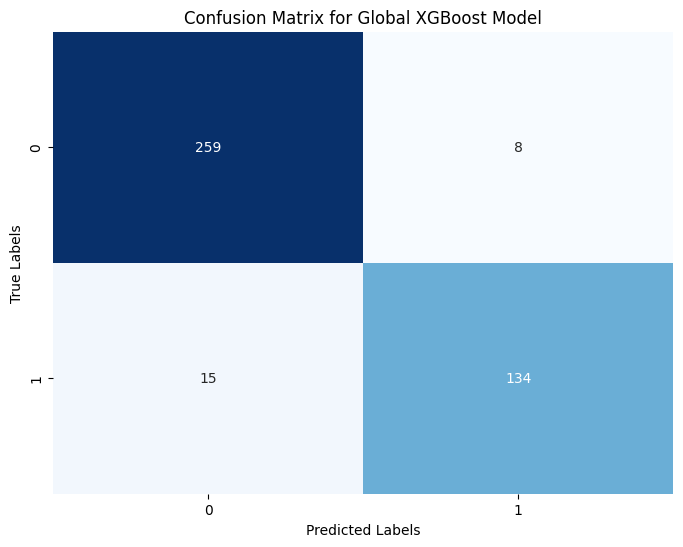

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(client3_y, xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Global XGBoost Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Random Forest Training Accuracy: 95.69%
Random Forest Testing Accuracy: 86.27%
Extra Trees Training Accuracy: 93.10%
Extra Trees Testing Accuracy: 90.20%
XGBoost Training Accuracy: 97.41%
Final Model Training Accuracy: 95.81%
XGBoost Testing Accuracy: 89.71%
Final Model Testing Accuracy: 88.73%


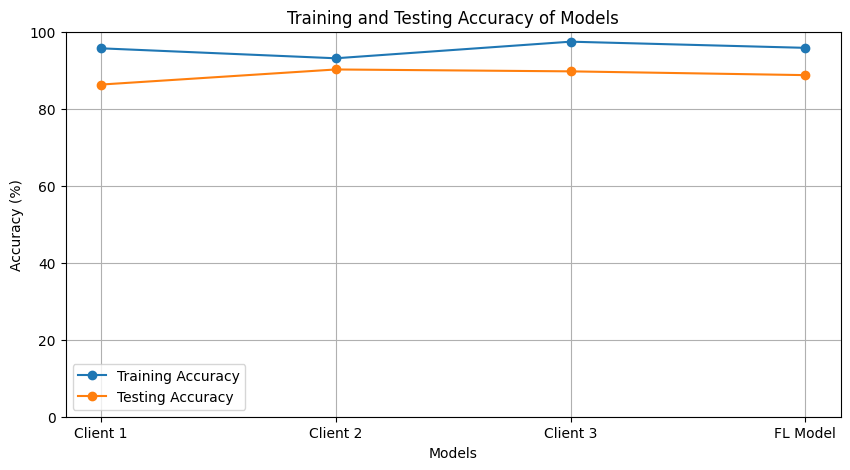

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

# Load the dataset from a CSV file
data = pd.read_csv('/content/Dataset of Heart failure Prediction.csv')
X = data.iloc[:, :-1].values  # input features
y = data.iloc[:, -1].values  # output labels

# Encode categorical columns
label_encoders = {}
categorical_columns = [1, 2, 6, 8, 10]  # Column indices of categorical features
for col_idx in categorical_columns:
    label_encoders[col_idx] = LabelEncoder()
    X[:, col_idx] = label_encoders[col_idx].fit_transform(X[:, col_idx])

# Convert data to the appropriate data type (float)
X = X.astype(float)
y = y.astype(float)

# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Define hyperparameter grids for models
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the models with GridSearchCV for hyperparameter tuning
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=5, n_jobs=-1)
et_model = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the models on the train data
rf_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)

# Get the best-tuned models
best_rf_model = rf_model.best_estimator_
best_et_model = et_model.best_estimator_

# Predict probabilities for each local model
rf_train_predictions = best_rf_model.predict(X_train)
rf_test_predictions = best_rf_model.predict(X_test)
et_train_predictions = best_et_model.predict(X_train)
et_test_predictions = best_et_model.predict(X_test)

# Calculate accuracies
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
et_train_accuracy = accuracy_score(y_train, et_train_predictions)
et_test_accuracy = accuracy_score(y_test, et_test_predictions)

# Print accuracies
print("Random Forest Training Accuracy: {:.2f}%".format(rf_train_accuracy * 100))
print("Random Forest Testing Accuracy: {:.2f}%".format(rf_test_accuracy * 100))
print("Extra Trees Training Accuracy: {:.2f}%".format(et_train_accuracy * 100))
print("Extra Trees Testing Accuracy: {:.2f}%".format(et_test_accuracy * 100))

# Fit the XGBoost global model with all train data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
xgb_model.fit(X_train_poly, y_train)

# Predict probabilities with the global XGBoost model on the training data
X_train_poly = poly.transform(X_train_scaled)
xgb_train_predictions = xgb_model.predict(X_train_poly)

# Calculate accuracy for the XGBoost global model on the training data
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
print("XGBoost Training Accuracy: {:.2f}%".format(xgb_train_accuracy * 100))

# Combine predictions from all local models and the global XGBoost model on the training data
final_train_predictions = np.array([rf_train_predictions, et_train_predictions, xgb_train_predictions])
final_train_class_labels = np.round(final_train_predictions.mean(axis=0)).astype(int)

# Calculate final training accuracy
final_train_accuracy = accuracy_score(y_train, final_train_class_labels)
print("Final Model Training Accuracy: {:.2f}%".format(final_train_accuracy * 100))

# Predict probabilities with the global XGBoost model on the test data
X_test_scaled = scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)
xgb_test_predictions = xgb_model.predict(X_test_poly)

# Calculate accuracy for the XGBoost global model on the test data
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
print("XGBoost Testing Accuracy: {:.2f}%".format(xgb_test_accuracy * 100))

# Combine predictions from all local models and the global XGBoost model on the test data
final_predictions = np.array([rf_test_predictions, et_test_predictions, xgb_test_predictions])
final_class_labels = np.round(final_predictions.mean(axis=0)).astype(int)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, final_class_labels)
print("Final Model Testing Accuracy: {:.2f}%".format(final_accuracy * 100))

# Plotting
models = ['Client 1', 'Client 2', 'Client 3', 'FL Model']
train_accuracies = [rf_train_accuracy * 100, et_train_accuracy * 100, xgb_train_accuracy * 100, final_train_accuracy * 100]
test_accuracies = [rf_test_accuracy * 100, et_test_accuracy * 100, xgb_test_accuracy * 100, final_accuracy * 100]

plt.figure(figsize=(10, 5))
plt.plot(models, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(models, test_accuracies, marker='o', label='Testing Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy of Models')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for the final prediction on training data
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, final_train_class_labels, average='binary')

# Print precision, recall, and F1-score for the final prediction on training data
print("Final Prediction:")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))


Final Prediction:
Precision: 0.95
Recall: 0.97
F1-score: 0.96


Final Model Validation Accuracy: 90.80%


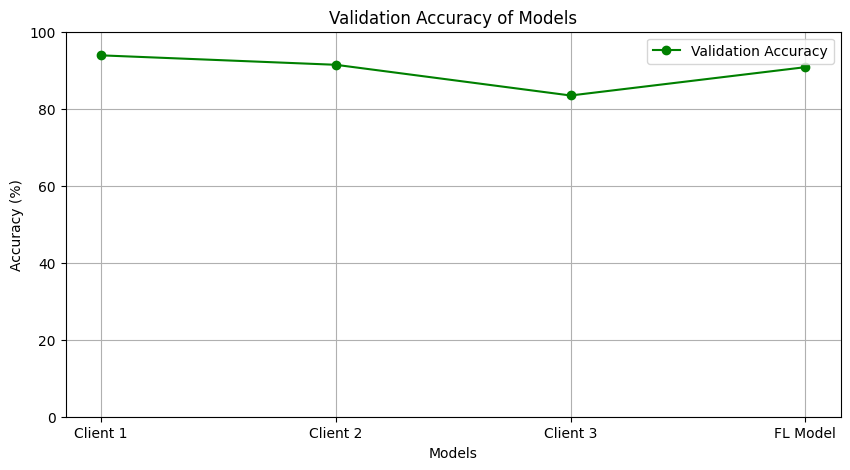

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit polynomial transformation on the training data
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_val_poly_scaled = scaler.transform(X_val_poly)

# Train and evaluate models on training and validation sets
rf_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)

# Predict probabilities for each local model on training and validation sets
rf_train_predictions = best_rf_model.predict(X_train)
rf_val_predictions = best_rf_model.predict(X_val)
et_train_predictions = best_et_model.predict(X_train)
et_val_predictions = best_et_model.predict(X_val)

# Calculate accuracies for validation sets
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
et_val_accuracy = accuracy_score(y_val, et_val_predictions)

# Fit the XGBoost global model with all train data
xgb_model.fit(X_train_poly_scaled, y_train)

# Predict probabilities with the global XGBoost model on the validation data
xgb_val_predictions = xgb_model.predict(X_val_poly_scaled)

# Calculate accuracy for the XGBoost global model on the validation data
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)

# Combine predictions from all local models and the global XGBoost model on the validation data
final_val_predictions = np.array([rf_val_predictions, et_val_predictions, xgb_val_predictions])
final_val_class_labels = np.round(final_val_predictions.mean(axis=0)).astype(int)

# Calculate final validation accuracy
final_val_accuracy = accuracy_score(y_val, final_val_class_labels)
print("Final Model Validation Accuracy: {:.2f}%".format(final_val_accuracy * 100))

# Plotting
models = ['Client 1', 'Client 2', 'Client 3', 'FL Model']
val_accuracies = [rf_val_accuracy * 100, et_val_accuracy * 100, xgb_val_accuracy * 100, final_val_accuracy * 100]

plt.figure(figsize=(10, 5))
plt.plot(models, val_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy of Models')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()


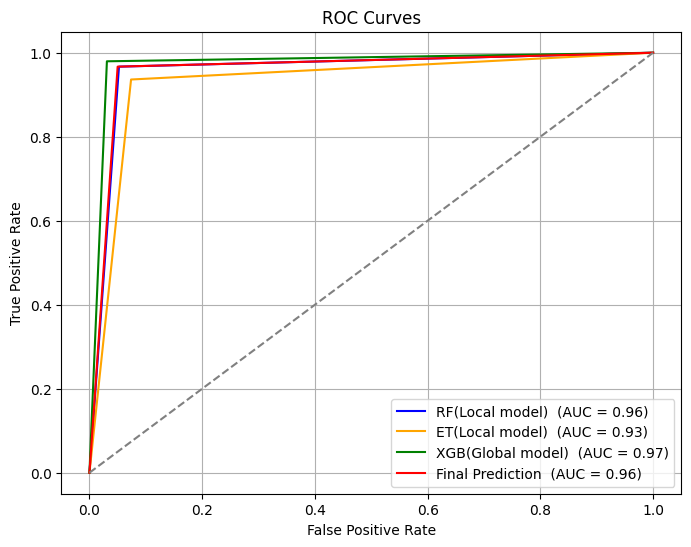

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curves and AUC scores for each model's predictions
rf_fpr_train, rf_tpr_train, _ = roc_curve(y_train, rf_train_predictions)
rf_auc_train = roc_auc_score(y_train, rf_train_predictions)
et_fpr_train, et_tpr_train, _ = roc_curve(y_train, et_train_predictions)
et_auc_train = roc_auc_score(y_train, et_train_predictions)
xgb_fpr_train, xgb_tpr_train, _ = roc_curve(y_train, xgb_train_predictions)
xgb_auc_train = roc_auc_score(y_train, xgb_train_predictions)
final_fpr_train, final_tpr_train, _ = roc_curve(y_train, final_train_class_labels)
final_auc_train = roc_auc_score(y_train, final_train_class_labels)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr_train, rf_tpr_train, linestyle='-', color='blue', label=f'RF(Local model)  (AUC = {rf_auc_train:.2f})')
plt.plot(et_fpr_train, et_tpr_train, linestyle='-', color='orange', label=f'ET(Local model)  (AUC = {et_auc_train:.2f})')
plt.plot(xgb_fpr_train, xgb_tpr_train, linestyle='-', color='green', label=f'XGB(Global model)  (AUC = {xgb_auc_train:.2f})')
plt.plot(final_fpr_train, final_tpr_train, linestyle='-', color='red', label=f'Final Prediction  (AUC = {final_auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


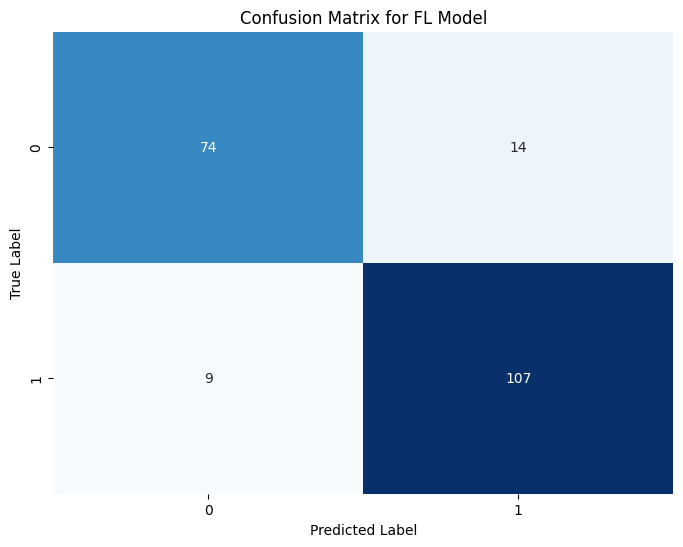

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix for final prediction
conf_matrix = confusion_matrix(y_test, final_class_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for FL Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
